# Visualize Density by Frame : 기본구간(1번 동영상)
0. `00_dataset_filtered`의 파일을 로드
1. 프레임 ID별 오름차순 정렬 - **시간순 정렬을 위함**
2. 프레임 ID별 Vehicle ID 수 산출 - **각 시간대별 차량 대수를 산정, 밀도 산출에 사용 **
3. **`구간길이`**를 사용하여 프레임별 밀도 산출
4. 프레임별 밀도를 Plotly를 사용한 시계열 그래프로 나타내기
5. 프레임별 밀도, LOS 평가 : 고속도로 기본구간 기준 적용
6. 각 대상지의 차량 궤적정보와 해당 프레임에서 LOS를 JOIN

## Imports

In [37]:
import datetime as dt
import os
import pandas as pd
import numpy as np

# Plotly : 인터랙티브 그래프를 그려주는 패키지
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

## Load Dataset

In [38]:
folder_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/Yonsei_TELab/003_도로상충_210517-/2차년도_2022/27_남양주영업소_드론영상분석/서울방향'
folder_name = '00_dataset_filtered_full' # 각 .csv 파일이 있는 폴더경로

file_dir = os.path.join(folder_dir, folder_name)

In [39]:
file_list = os.listdir(file_dir)
file_list[0:3]

['01_1.csv', '01_2.csv', '01_3.csv']

In [40]:
# 파일명으로부터 대상지 번호, 촬영 순서, 영상번호를 추출
tgs = [] # 촬영 대상지 번호
spots = [] # 촬영 지점

for file in file_list: # 전체 파일 리스트를 돌며
    tg = file[0:2] # 파일명으로부터 촬영 대상지 번호(2자리) 추출
    spot = file[3] # 파일명으로부터 촬영지점(1자리) 추출
    
    if tg not in tgs:
        tgs.append(tg)
        
    if spot not in spots:
        spots.append(spot)
    
print(tgs, '\n', spots)

['01', '02', '03', '04'] 
 ['1', '2', '3']


In [41]:
# concate 된 파일을 기준으로 데이터프레임 리스트와 넘버링 리스트를 다시 재정의하기

df_list = [] # 데이터프레임 리스트 초기화
num_list = [] # 데이터프레임 파일명, 즉 넘버링 리스트 초기화

for tg in tgs:
    for sp in spots:
        num = tg + '_' + sp # 파일명 넘버링
        file_name = num + '.csv'
        file_path = os.path.join(file_dir, file_name)
            
        if os.path.isfile(file_path): # 해당 file_path에 파일이 존재할 경우
            globals()[f'target{num}'] = pd.read_csv(file_path, encoding = 'cp949') # .csv 파일을 불러와 인스턴스 만들기
            df_list.append(globals()[f'target{num}']) 
            num_list.append(num)

In [42]:
num_list

['01_1',
 '01_2',
 '01_3',
 '02_1',
 '02_2',
 '02_3',
 '03_1',
 '03_2',
 '04_1',
 '04_2',
 '04_3']

## Time-RCD
* 시간을 나타내는 파생변수 `time_rcd`(초)를 생성

In [43]:
frame_rate = 30 # 30프레임으로 수집된 데이터임

In [44]:
for df, num in zip(df_list, num_list):
    first_time = df['Frame ID'][0] # 첫 시점(프레임 ID)
    df['time_rcd'] = (df['Frame ID'] - first_time)/frame_rate # time_rcd 라는 (초)단위의 컬럼을 생성

## Vehicles by Frames
* 각 프레임별 차량대수를 산정(프레임별 밀도를 계산하기 위함)
* 프레임 ID별 오름차순 정렬, 정렬 결과 자체 저장
* 프레임 ID별 Vehicle ID 개수(차량대수) 산출

In [45]:
pivot_list = []

for df, num in zip(df_list, num_list):
    
    df.sort_values(by = ['Frame ID'], axis = 0, inplace = True) #프레임 ID에 대하여 오름차순 정렬하여 각 데이터프레임을 저장
    
    pv = pd.pivot_table(df, index = ['Frame ID'], values = 'Vehicle ID', aggfunc = 'count') # 각 프레임ID별 Vehicle ID 개수(=차량대수)를 세어 피벗테이블 생성
    
    pv['place'] = num # Mutate :: Target(Place) Numbering
    pv['FrameID'] = pv.index # FrameID를 인덱스로 설정함
    globals()[f'pivot{num}'] = pv
    
    pivot_list.append(pv)

## Calculate Density
* 프레임별 밀도를 시계열 그래프로 나타내기
* **주의!** 본 코드의 밀도는 실제 분석에 사용되는 값이 아닙니다! 프레임 존재여부를 체크하기 위함입니다!
    * 영업소는 LOS를 측정하지 않습니다.

### Load Target Info
* 대상지 기본정보 불러오기 : **사전에 작성해야 합니다**
    * `place` : 대상지 번호(tg_spot)
    * `length` : 대상지 길이(m) -- **드론촬영영상 궤적추출시 미리 입력해야 합니다**
    * `speed_limit` : 대상지 제한속도(km/h)
    * `lane_num` : 차선 수(개)

In [46]:
info_file = 'target_info_A_MH.csv' #대상지 정보가 든 파일명 입력

In [47]:
target_info = pd.read_csv(info_file, encoding = 'utf-8')

In [48]:
target_info.head()

,place,length,speed_limit,lane_num,order,etc
0,01_1,264,80,3,NaN,NaN
1,01_2,264,30,4,NaN,NaN
2,01_3,264,30,4,NaN,NaN
3,02_1,264,80,6,NaN,NaN
4,02_2,264,30,6,NaN,NaN


## Calculate Density
* 각 촬영지점의 프레임별 밀도, LOS를 산정

### LOS 판정 함수 정의

In [49]:
def LOS_expwy_basic(x:int):
    """밀도를 바탕으로 LOS를 판정해 주는 함수 :: 고속도로 기본구간 기준"""
    
    if x >= 0 and x <= 6:
        return 'A'
    elif x > 6 and x <= 10:
        return 'B'
    elif x > 10 and x <= 14:
        return 'C'
    elif x > 14 and x <= 19:
        return 'D'
    elif x > 19 and x <= 28:
        return 'E'
    elif x > 28:
        return 'F'
    
    else:
        pass

### 밀도 및 LOS 계산

In [50]:
density_list = []

for pv, num in zip(pivot_list, num_list):
    
    dst = pd.merge(left = pv, right = target_info, how = 'inner', left_on = 'place', right_on = 'place') # 대상지 촬영지점에 대하여 JOIN
    
    dst['density'] = dst['Vehicle ID'] / dst['length'] / dst['lane_num'] * 1000 # 밀도 : pcpkmpl. 1km내에 1차로당 든 차량의 대수
    
    dst['LOS'] = dst['density'].apply(LOS_expwy_basic)
    
    globals()[f'density{num}'] = dst
    density_list.append(dst)

In [51]:
density_list[0]

,Vehicle ID,place,FrameID,length,speed_limit,lane_num,order,etc,density,LOS
0,1,01_1,375,264,80,3,NaN,NaN,1.262626,A
1,2,01_1,390,264,80,3,NaN,NaN,2.525253,A
2,2,01_1,405,264,80,3,NaN,NaN,2.525253,A
3,2,01_1,420,264,80,3,NaN,NaN,2.525253,A
4,2,01_1,435,264,80,3,NaN,NaN,2.525253,A
...,...,...,...,...,...,...,...,...,...,...
1712,12,01_1,208910,264,80,3,NaN,NaN,15.151515,D
1713,13,01_1,208925,264,80,3,NaN,NaN,16.414141,D
1714,13,01_1,208940,264,80,3,NaN,NaN,16.414141,D
1715,13,01_1,208955,264,80,3,NaN,NaN,16.414141,D


## Draw Line Graph for Density
* `01_density_by_frame`에 .csv 파일과 Plotly .html 파일을 저장
* 저장된 Plotly 파일은 LOS별 프레임 추출에 사용될 것

In [52]:
save_folder_name = '01_frame'

save_dir = os.path.join(folder_dir, save_folder_name)

os.makedirs(save_dir, exist_ok = True) # 해당 경로가 없을 시 폴더 생성, 존재할 경우 건너뛰기

In [53]:
for dst, num in zip(density_list, num_list):
    
    fig = px.line(dst, x = 'FrameID', y = 'density', title = f'Density : target{num}')
    
    save_html_name = f'{num}.html'
    save_html_path = os.path.join(save_dir, save_html_name)
    
    po.write_html(fig, file = save_html_path) # html Plotly 파일 저장
    
    save_csv_name = f'{num}.csv'
    save_csv_path = os.path.join(save_dir, save_csv_name)
    
    dst.to_csv(save_csv_path, encoding = 'cp949') # 프레임별 밀도, LOS .csv 파일 저장

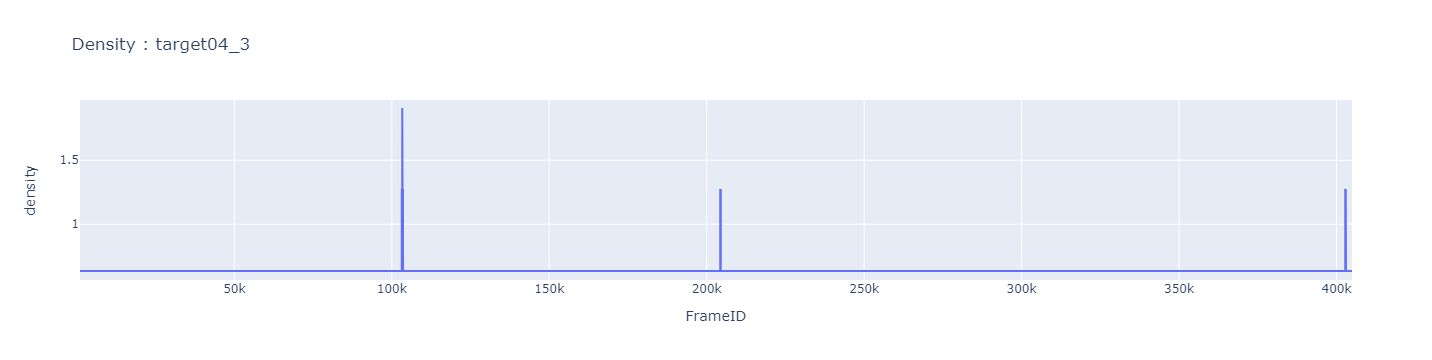

In [54]:
fig.show()